# Starbucks Capstone Challenge

#### Project overview

In the final project, I address the question:

How accurate is it to predict whether or not an offer in the Starbucks rewards app will be accepted by a customer group?

The data is provided by Udacity as part of the Data Scientist Nanodegree course. It is synthetic data used to simulate customer behavior in the Starbucks Rewards mobile app.

The marketing process with the mobile app is characterized by Starbucks sending offers to mobile app users every few days. Not all customers receive the same offer. It is also possible that some customers do not receive any offer at all in certain weeks.


#### Problem Statement

To clarify the core question: The accuracy of the prediction of how a customer will react to an offer should be determined. It's less about the facts of the matter, how he decides.

A refinement of the question is then also the point of how the accuracy of the prediction for a customer group differs for two different offers.

For this purpose, the customers were divided into customer-specific groups for each portfolio type:
- by gender
- by age
- by income

For analysis, I used 3 classification-supervised machine learning models, which were used to determine the accuracy of the predictions.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
from pandas import json_normalize
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import fbeta_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import math
import json
import copy
from scipy.stats import gmean

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Investigate the files and clean the data

#### Investigate portfolio

In [2]:
# Take a look on portfolio
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
# Convert list strings in csv strings in "channels"  
portfolio['channels'] = [','.join(ch) for ch in portfolio['channels']]

In [4]:
# Separate the categories in "channels"
email_ls = []
mobile_ls = []
social_ls = []
web_ls = []

for ch in portfolio['channels']:
    
    email = 0
    mobile = 0
    social = 0
    web = 0
    
    if 'email' in ch:
        email = 1
    email_ls.extend([email])
    if 'mobile' in ch:
        mobile = 1
    mobile_ls.extend([mobile])
    if 'social' in ch:
        social = 1
    social_ls.extend([social])
    if 'web' in ch:
        web = 1
    web_ls.extend([web])


In [5]:
# New rows for the channels
portfolio['email'] = email_ls 
portfolio['mobile'] = mobile_ls 
portfolio['social'] = social_ls
portfolio['web'] = web_ls

In [6]:
# Take a look on portfolio
portfolio

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"email,mobile,social",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"web,email,mobile,social",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"web,email,mobile",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"web,email,mobile",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"web,email",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,"web,email,mobile,social",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"web,email,mobile,social",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"email,mobile,social",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,"web,email,mobile,social",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"web,email,mobile",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [7]:
# Hot encoding "offer_type"
offer_types = pd.get_dummies(portfolio['offer_type'])

In [8]:
# Concat offer_types to portfolio
portfolio = pd.concat([portfolio, offer_types], axis=1, sort=False)

In [9]:
# Take a look on portfolio
portfolio

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"email,mobile,social",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"web,email,mobile,social",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"web,email,mobile",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"web,email,mobile",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"web,email",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,"web,email,mobile,social",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,"web,email,mobile,social",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,"email,mobile,social",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,"web,email,mobile,social",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"web,email,mobile",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [10]:
# Remove the columns no longer needed
portfolio = portfolio.drop(columns = ['channels'])
portfolio = portfolio.drop(columns = ['offer_type'])

In [11]:
# Rename column "id"
portfolio.rename(columns={'id':'offer_id'}, inplace = True)

In [12]:
# Take a look on portfolio
portfolio

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


#### Investigate profile

In [13]:
# Now take a look on profile
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
# At first rename column "id"
profile.rename(columns={'id':'customer_id'}, inplace = True)

In [15]:
# More information about profile
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   customer_id       17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [16]:
# What is the number of unique customer
profile.customer_id.nunique()

17000

In [17]:
profile

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


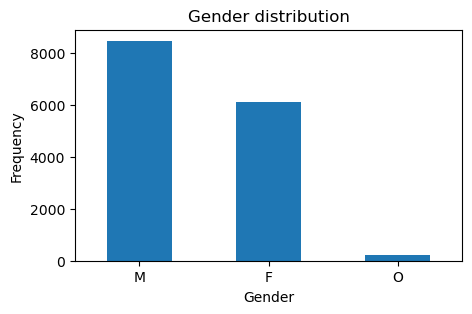

In [18]:
# Take a look on the gender distribution
profile.gender.value_counts().plot.bar(figsize = (5, 3), fontsize=10) 
plt.title("Gender distribution")
plt.xlabel("Gender", fontsize=10)
plt.ylabel("Frequency", fontsize = 10)
plt.xticks(rotation = 0)
plt.show()




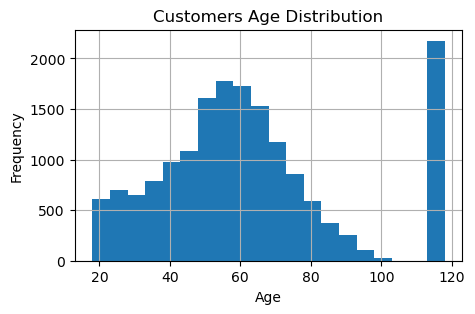

In [19]:
# Take a closer look on the age distribution
profile.hist(column = "age", figsize = (5, 3), bins = 20)
plt.title("Customers Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [20]:
# Take a look on datasets with age = 118, first 5 rows
profile[profile.age == 118][['age', 'income', 'gender']][:5]

,age,income,gender
0,118,NaN,None
2,118,NaN,None
4,118,NaN,None
6,118,NaN,None
7,118,NaN,None


In [21]:
# Take a look on datasets with age = 118, last 5 rows
profile[profile.age == 118][['age', 'income', 'gender']][-5:]

,age,income,gender
16980,118,NaN,None
16982,118,NaN,None
16989,118,NaN,None
16991,118,NaN,None
16994,118,NaN,None


In [22]:
# Null values in profile
profile.isnull().sum()

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
dtype: int64

In [23]:
# Datasets with age > 101
profile.age[profile['age'] > 101].count()

2175

It appears that in all records with age > 101, the values ​​for gender and income are None and Nans (null values), respectively. Also, the datasets with age > 101 appear to be outliers. All records with age > 101 have the value age = 118. To remove the null values ​​from profile, age = 118 is set to NaN and then the null values ​​are removed from profile. 

In [24]:
# Set age = NaN for age = 118
profile.loc[profile.age == 118,'age'] = np.nan

In [25]:
# Null values in profile
profile.isnull().sum()

gender              2175
age                 2175
customer_id            0
became_member_on       0
income              2175
dtype: int64

In [26]:
# Remove null values from profile
profile.dropna(inplace = True)

In [27]:
# Check null values in profile
profile.isnull().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
dtype: int64

In [28]:
# Distribution of gender
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

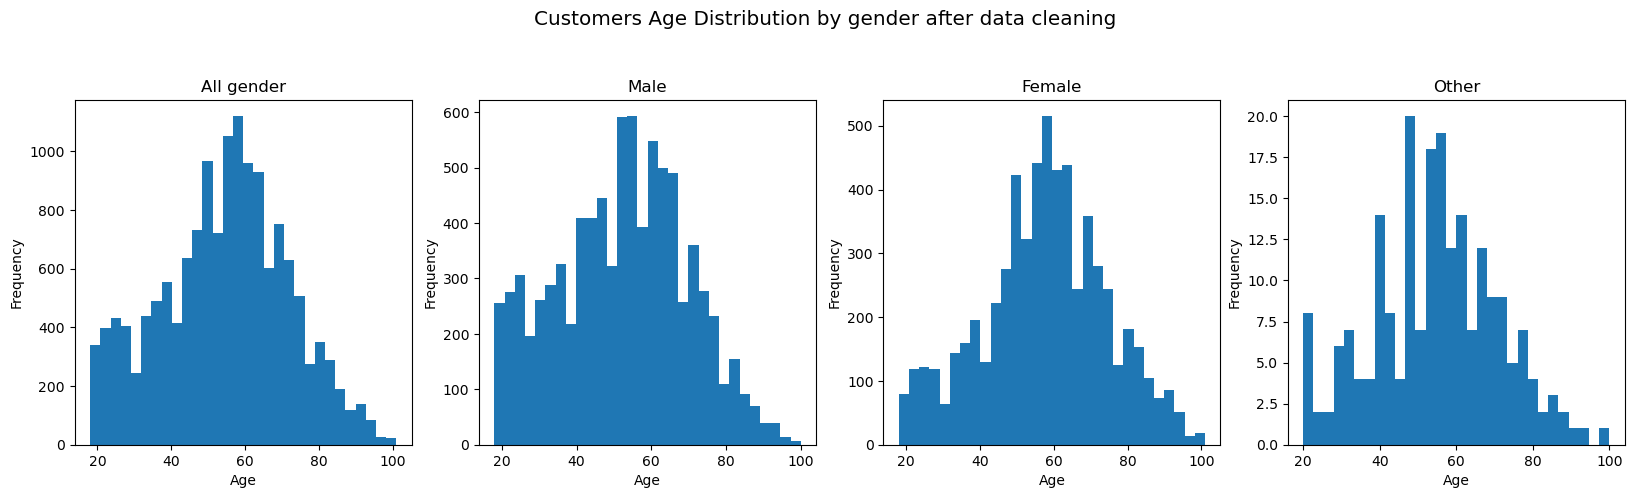

In [216]:
# Take a look on the age distribution by gender w/o age = 118
fig, ax = plt.subplots(1, 4, figsize=(20,5))
plt.sca(ax[0])
plt.hist(profile['age'], bins = 30)
plt.title('All gender')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.sca(ax[1])
plt.hist(profile['age'][profile['gender'] == 'M'], bins = 30)
plt.title('Male')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.sca(ax[2])
plt.hist(profile['age'][profile['gender'] == 'F'], bins = 30)
plt.title('Female')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.sca(ax[3])
plt.hist(profile['age'][profile['gender'] == 'O'], bins = 30)
plt.title('Other')
plt.xlabel('Age')
plt.ylabel('Frequency')

fig.suptitle('Customers Age Distribution by gender after data cleaning', fontsize='x-large')
fig.subplots_adjust(top = 0.8)

In [30]:
# What are the mean ages in profile by gender
mean_age_all = gmean(profile['age'])

profile_male = profile.loc[profile['gender'] == 'M']
mean_age_male = gmean(profile_male['age'])

profile_female = profile.loc[profile['gender'] == 'F']
mean_age_female = gmean(profile_female['age'])

profile_other = profile.loc[profile['gender'] == 'O']
mean_age_other = gmean(profile_other['age'])

print("The mean age by all gender is {:.1f} years".format(mean_age_all))
print("The mean age by males is {:.1f} years".format(mean_age_male))   
print("The mean age by females is {:.1f} years".format(mean_age_female))
print("The mean age by other is {:.1f} years".format(mean_age_other))

The mean age by all gender is 51.2 years
The mean age by males is 48.8 years
The mean age by females is 54.7 years
The mean age by other is 51.7 years


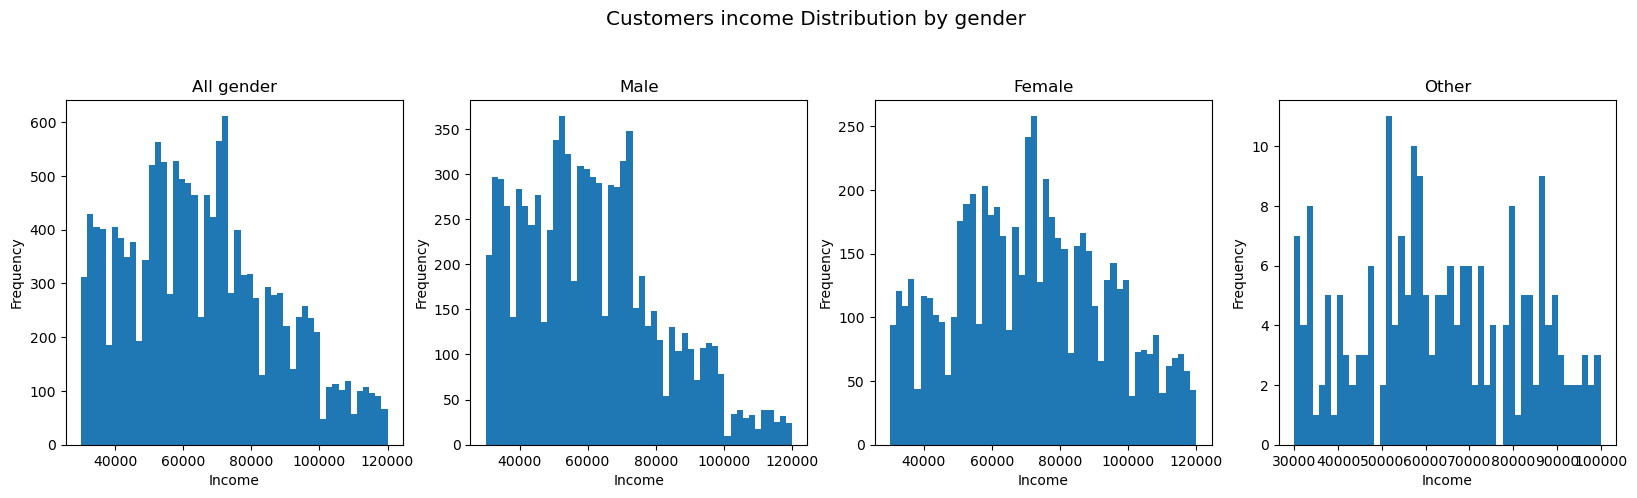

In [217]:
# Take a look on the income distribution by gender
fig, ax = plt.subplots(1, 4, figsize=(20,5))
plt.sca(ax[0])
plt.hist(profile['income'], bins = 50)
plt.title('All gender')
plt.xlabel('Income')
plt.ylabel('Frequency')

plt.sca(ax[1])
plt.hist(profile['income'][profile['gender'] == 'M'], bins = 50)
plt.title('Male')
plt.xlabel('Income')
plt.ylabel('Frequency')

plt.sca(ax[2])
plt.hist(profile['income'][profile['gender'] == 'F'], bins = 50)
plt.title('Female')
plt.xlabel('Income')
plt.ylabel('Frequency')

plt.sca(ax[3])
plt.hist(profile['income'][profile['gender'] == 'O'], bins = 50)
plt.title('Other')
plt.xlabel('Income')
plt.ylabel('Frequency')

fig.suptitle('Customers income Distribution by gender', fontsize='x-large')
fig.subplots_adjust(top = 0.8)

In [32]:
# What are the mean incomes in profile by gender
mean_income_all = gmean(profile['income'])

profile_male = profile.loc[profile['gender'] == 'M']
mean_income_male = gmean(profile_male['income'])

profile_female = profile.loc[profile['gender'] == 'F']
mean_income_female = gmean(profile_female['income'])

profile_other = profile.loc[profile['gender'] == 'O']
mean_income_other = gmean(profile_other['income'])

print("The mean income by all gender is {:.1f}".format(mean_income_all))
print("The mean income by males is {:.1f}".format(mean_income_male))   
print("The mean income by females is {:.1f}".format(mean_income_female))
print("The mean income by other is {:.1f}".format(mean_income_other))

The mean income by all gender is 61814.1
The mean income by males is 57987.8
The mean income by females is 67589.8
The mean income by other is 60266.0


In [33]:
# Now take a look on profile
profile.head()

,gender,age,customer_id,became_member_on,income
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


#### Investigate transcript

In [34]:
# Take a look on transcript
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [35]:
# Check on missing value
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [36]:
# Rename column "person"
transcript.rename(columns={'person':'customer_id'}, inplace = True)

In [37]:
# Extract "value"
value = pd.json_normalize(transcript['value'])
transcript = pd.concat([transcript, value], axis=1)
value.count()

offer id    134002
amount      138953
offer_id     33579
reward       33579
dtype: int64

In [38]:
# Hot encoding "event"
events = pd.get_dummies(transcript['event'])

In [39]:
# Concat events to transcript
transcript = pd.concat([transcript, events], axis=1, sort=False)

In [40]:
transcript.head()

,customer_id,event,value,time,offer id,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,0,1,0,0


In [41]:
# Check on missing value after extracting
transcript.isnull().sum()

customer_id             0
event                   0
value                   0
time                    0
offer id           172532
amount             167581
offer_id           272955
reward             272955
offer completed         0
offer received          0
offer viewed            0
transaction             0
dtype: int64

In [42]:
# Merge offer_id column and offer id column
transcript['offer_id'] = np.where(pd.isnull(transcript['offer_id']), transcript['offer id'], transcript['offer_id'])

In [43]:
# Remove the columns no longer needed
transcript = transcript.drop(columns = ['value'])
transcript = transcript.drop(columns = ['offer id'])
transcript = transcript.drop(columns = ['event'])

In [44]:
# Fill 0 in NaN
transcript.fillna(0, inplace=True)
transcript.head(5)

,customer_id,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,1,0,0


#### Merge 'portfolio' and 'transcript' on offer id and 'profile' on customer id

In [45]:
# Merge portfolio and transcript and profile (1)
port_trans = pd.merge(portfolio, transcript, on = 'offer_id', how = 'inner')

In [46]:
# Merge portfolio and transcript and profile (2)
port_trans_prof = pd.merge(port_trans, profile, on = 'customer_id', how = 'inner')

In [47]:
# Take a look on port_trans_prof
pd.set_option('display.max_columns', 30)
port_trans_prof.head()

,reward_x,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational,customer_id,time,amount,reward_y,offer completed,offer received,offer viewed,transaction,gender,age,became_member_on,income
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,0,1,0,0,M,64.0,20170909,100000.0
1,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,0,0,1,0,M,64.0,20170909,100000.0
2,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,0,1,0,0,M,64.0,20170909,100000.0
3,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,0,0,1,0,M,64.0,20170909,100000.0
4,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,10.0,1,0,0,0,M,64.0,20170909,100000.0


In [48]:
# Sorting the columns
old_column_sort = port_trans_prof.columns.values.tolist()
print(old_column_sort)
new_column_sort = ['reward_x', 'difficulty', 'duration', 'time', 'offer_id', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational', 'customer_id', 'amount', 'reward_y', 'offer completed', 'offer received', 'offer viewed', 'transaction', 'gender', 'age', 'became_member_on', 'income']
port_trans_prof = port_trans_prof.reindex(columns = ['reward_x', 'difficulty', 'duration', 'time', 'offer_id', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational', 'customer_id', 'amount', 'reward_y', 'offer completed', 'offer received', 'offer viewed', 'transaction', 'gender', 'age', 'became_member_on', 'income'])
port_trans_prof.head()

['reward_x', 'difficulty', 'duration', 'offer_id', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational', 'customer_id', 'time', 'amount', 'reward_y', 'offer completed', 'offer received', 'offer viewed', 'transaction', 'gender', 'age', 'became_member_on', 'income']


,reward_x,difficulty,duration,time,offer_id,email,mobile,social,web,bogo,discount,informational,customer_id,amount,reward_y,offer completed,offer received,offer viewed,transaction,gender,age,became_member_on,income
0,10,10,7,0,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.0,0,1,0,0,M,64.0,20170909,100000.0
1,10,10,7,102,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.0,0,0,1,0,M,64.0,20170909,100000.0
2,10,10,7,504,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.0,0,1,0,0,M,64.0,20170909,100000.0
3,10,10,7,510,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.0,0,0,1,0,M,64.0,20170909,100000.0
4,10,10,7,510,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,10.0,1,0,0,0,M,64.0,20170909,100000.0


In [49]:
# Normalize Numerical Features
scaler = MinMaxScaler()

numericals = port_trans_prof.columns[0:4]
port_trans_prof = pd.DataFrame(data = port_trans_prof)
port_trans_prof[numericals] = scaler.fit_transform(port_trans_prof[numericals])

#numericals = port_trans_prof.columns[12]
#port_trans_prof = pd.DataFrame(data = port_trans_prof)
#port_trans_prof[numericals] = scaler.fit_transform(port_trans_prof[numericals])

port_trans_prof.head()

,reward_x,difficulty,duration,time,offer_id,email,mobile,social,web,bogo,discount,informational,customer_id,amount,reward_y,offer completed,offer received,offer viewed,transaction,gender,age,became_member_on,income
0,1.0,0.5,0.571429,0.000000,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.0,0,1,0,0,M,64.0,20170909,100000.0
1,1.0,0.5,0.571429,0.142857,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.0,0,0,1,0,M,64.0,20170909,100000.0
2,1.0,0.5,0.571429,0.705882,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.0,0,1,0,0,M,64.0,20170909,100000.0
3,1.0,0.5,0.571429,0.714286,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.0,0,0,1,0,M,64.0,20170909,100000.0
4,1.0,0.5,0.571429,0.714286,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,10.0,1,0,0,0,M,64.0,20170909,100000.0


### Investigation of the portfolio types 'BOGO', 'discount' and  'informational'
For the portfolio types 'BOGO' and 'discount', the following steps must be followed so that the transaction can be completed successfully:

 - offered viewed --> offer received --> offer completed

Any deviation from this will result in an incomplete transaction.

For portfolio type 'informational', the steps

 - offer received --> offer completed 

must be followed so that the transaction can be completed successfully. Again, any deviation from the required steps will result in an incomplete transaction.



#### Compute 'BOGO' transaction status

In [50]:
# Compute the status of the transaction for bogo for the customers

# Only bogo transactions
bogo_port_trans_prof = port_trans_prof[port_trans_prof['bogo'] == 1]

# Select customer with informational portfolie types
custom_id_b = bogo_port_trans_prof['customer_id'].unique()

bogo_transaction_status = []

# Loop over all customers 
for cust in custom_id_b:
    bogo_cust = bogo_port_trans_prof[bogo_port_trans_prof['customer_id'] == str(cust)]

    # Select offers, only offers for the selected customer     
    offer_id_b = bogo_cust['offer_id'].unique()
         
    # Loop over all offers of selected customer
    for of in offer_id_b:
        offer_viewed = np.array(bogo_cust['offer viewed'][bogo_cust['customer_id'] == str(cust)][bogo_cust['offer_id'] == str(of)])
        offer_received = np.array(bogo_cust['offer received'][bogo_cust['customer_id'] == str(cust)][bogo_cust['offer_id'] == str(of)])
        offer_completed = np.array(bogo_cust['offer completed'][bogo_cust['customer_id'] == str(cust)][bogo_cust['offer_id'] == str(of)])

        if np.any(offer_viewed) and np.any(offer_received) and np.any(offer_completed):
            bogo_transaction_status.append('Completed')
        else: 
            bogo_transaction_status.append('Not Completed')



In [51]:
# Number of all and completed/not completed BOGO transactions
bogo = bogo_port_trans_prof[bogo_port_trans_prof['bogo'] == 1]
bogo = bogo.drop_duplicates(subset = ['customer_id','offer_id'])

bogo['transaction'] = bogo_transaction_status

bogo_t_s_total = len(bogo_transaction_status)
bogo_t_s_completed_c = bogo_transaction_status.count('Completed')
bogo_t_s_notcompleted_c = bogo_transaction_status.count('Not Completed')

print("BOGO transactions all: {}".format(bogo_t_s_total))
print("BOGO transactions Completed: {}".format(bogo_t_s_completed_c))
print("BOGO transactions Not Completed: {}".format(bogo_t_s_notcompleted_c))

BOGO transactions all: 22062
BOGO transactions Completed: 11496
BOGO transactions Not Completed: 10566


#### Conclusion for portfolio type 'BOGO'
In the case of the 'BOGO' portfolio type, the transaction statuses 'Completed' and 'Not Completed' are roughly evenly distributed. This distribution is very helpful and also necessary, since the data sets are split according to 'gender', 'age' and 'income' in the further course of the investigation.

#### Compute 'discount' transaction status

In [52]:
# Compute the status of the transaction for discount for the customers

# Only discount transactions
discount_port_trans_prof = port_trans_prof[port_trans_prof['discount'] == 1]

# Select customer with informational portfolie types
custom_id_d = discount_port_trans_prof['customer_id'].unique()

discount_transaction_status = []

# Loop over all customers 
for cust in custom_id_d:
    discount_cust = discount_port_trans_prof[discount_port_trans_prof['customer_id'] == str(cust)]

    # Select offers, only offers for the selected customer       
    offer_id_d = discount_cust['offer_id'].unique()
         
    # Loop over all offers of selected customer
    for of in offer_id_d:
        offer_viewed = np.array(discount_cust['offer viewed'][discount_cust['customer_id'] == str(cust)][discount_cust['offer_id'] == str(of)])
        offer_received = np.array(discount_cust['offer received'][discount_cust['customer_id'] == str(cust)][discount_cust['offer_id'] == str(of)])
        offer_completed = np.array(discount_cust['offer completed'][discount_cust['customer_id'] == str(cust)][discount_cust['offer_id'] == str(of)])

        if np.any(offer_viewed) and np.any(offer_received) and np.any(offer_completed):
            discount_transaction_status.append('Completed')
        else: 
            discount_transaction_status.append('Not Completed')



In [53]:
# Number of completed/not completed discount transactions
discount = discount_port_trans_prof[discount_port_trans_prof['discount'] == 1]
discount = discount.drop_duplicates(subset = ['customer_id','offer_id'])

discount['transaction'] = discount_transaction_status

discount_t_s_total = len(discount_transaction_status)
discount_t_s_completed_c = discount_transaction_status.count('Completed')
discount_t_s_notcompleted_c = discount_transaction_status.count('Not Completed')

print("discount transactions all: {}".format(discount_t_s_total))
print("discount transactions Completed: {}".format(discount_t_s_completed_c))
print("discount transactions Not Completed: {}".format(discount_t_s_notcompleted_c))

discount transactions all: 22119
discount transactions Completed: 12003
discount transactions Not Completed: 10116


#### Conclusion for portfolio type 'discount'
In the case of the 'discount' portfolio type, the transaction statuses 'Completed' and 'Not Completed' are roughly evenly distributed like in the 'BOGO' portfolio type. This distribution is very helpful and also necessary, since the data sets are split according to 'gender', 'age' and 'income' in the further course of the investigation.

#### Compute 'informational' transaction status

In [54]:
# Compute the status of the transaction for informational for the customers

# Only informational transactions
informational_port_trans_prof = port_trans_prof[port_trans_prof['informational'] == 1]

# Select customer with informational portfolie types
custom_id_i = informational_port_trans_prof['customer_id'].unique()

informational_transaction_status = []

# Loop over all customers 
for cust in custom_id_i:
    informational_cust = informational_port_trans_prof[informational_port_trans_prof['customer_id'] == str(cust)]

    # Select offers, only offers for the selected customer    
    offer_id_i = informational_cust['offer_id'].unique()
         
    # Loop over all offers of selected customer
    for of in offer_id_i:
        offer_received = np.array(informational_cust['offer received'][informational_cust['customer_id'] == str(cust)][informational_cust['offer_id'] == str(of)])
        offer_completed = np.array(informational_cust['offer completed'][informational_cust['customer_id'] == str(cust)][informational_cust['offer_id'] == str(of)])

        if np.any(offer_received) and np.any(offer_completed):
            informational_transaction_status.append('Completed')
        else: 
            informational_transaction_status.append('Not Completed')

In [55]:
# Number of completed/not completed informational transactions
informational = informational_port_trans_prof[informational_port_trans_prof['informational'] == 1]
informational = informational.drop_duplicates(subset = ['customer_id','offer_id'])

informational['transaction'] = informational_transaction_status

informational_t_s_total = len(informational_transaction_status)
informational_t_s_completed_c = informational_transaction_status.count('Completed')
informational_t_s_notcompleted_c = informational_transaction_status.count('Not Completed')

print("informational transactions all: {}".format(informational_t_s_total))
print("informational transactions Completed: {}".format(informational_t_s_completed_c))
print("informational transactions Not Completed: {}".format(informational_t_s_notcompleted_c))

informational transactions all: 11041
informational transactions Completed: 0
informational transactions Not Completed: 11041


#### Conclusion for portfolio type 'informational'
With the portfolio type 'Informational', the transaction status is 'Not Completed' across all consumers. Apparently no transaction was carried out for this portfolio in the required manner. Although only Not Completed transactions are available, the Informational portfolio type data is used for further investigation.

But: The accuracy for the transaction should be calculated in the later train data and in the test data. Due to the situation in the data, it is to be expected that for all 'informational' data will be accuracy = 1. This leads to the realization that with this data a prediction does not bring any knowledge with it. We will see...

### Remove columns that are no longer needed in the 'BOGO', 'discount' and 'informational' data
#### Replace values in 'gender' and 'transaction'

In [56]:
# Replace values in 'gender' and 'transaction'
bogo['gender'] = bogo['gender'].replace(['M', 'F', 'O'], [0, 1, 2])
discount['gender'] = discount['gender'].replace(['M', 'F', 'O'], [0, 1, 2])
informational['gender'] = informational['gender'].replace(['M', 'F', 'O'], [0, 1, 2])

bogo['transaction'] = bogo['transaction'].replace(['Not Completed', 'Completed'], [0, 1])
discount['transaction'] = discount['transaction'].replace(['Not Completed', 'Completed'], [0, 1])
informational['transaction'] = informational['transaction'].replace(['Not Completed', 'Completed'], [0, 1])

#### Value checks in 'amout' and 'reward_y'

In [57]:
# Check in bogo the values in 'amount' and 'reward_y'
print("sum value of 'amount' in bogo: {}".format(bogo['amount'].sum()))
print("sum value of 'reward_y' in bogo: {}".format(bogo['reward_y'].sum()))

sum value of 'amount' in bogo: 0.0
sum value of 'reward_y' in bogo: 0.0


In [58]:
# Check values in discount the in 'amount' and 'reward_y'
print("sum value of 'amount' in discount: {}".format(discount['amount'].sum()))
print("sum value of 'reward_y' in discount: {}".format(discount['reward_y'].sum()))

sum value of 'amount' in discount: 0.0
sum value of 'reward_y' in discount: 0.0


In [59]:
# Check values in informational the in 'amount' and 'reward_y'
print("sum value of 'amount' in informational: {}".format(informational['amount'].sum()))
print("sum value of 'reward_y' in informational: {}".format(informational['reward_y'].sum()))

sum value of 'amount' in informational: 0.0
sum value of 'reward_y' in informational: 0.0


#### Conclusion for value check
In 'BOGO', 'discount' and 'informational' all values in 'amount' and 'reward_y' are 0. This provides no distinguishing feature for the data sets. This '0' information is therefore not required to use the prediction model and can be removed.

#### Remome columns

In [60]:
# Remove columns 'BOGO' data
bogo = bogo.drop(columns=['offer_id',
                          'customer_id',
                          'bogo',
                          'discount',
                          'informational',
                          'offer completed',
                          'offer viewed',
                          'offer received',
                          'amount',
                          'reward_y'])

In [61]:
# Remove columns 'discount' data
discount = discount.drop(columns=['offer_id',
                          'customer_id',
                          'bogo',
                          'discount',
                          'informational',
                          'offer completed',
                          'offer viewed',
                          'offer received',
                          'amount',
                          'reward_y'])

In [62]:
# Remove columns 'informational' data
informational = informational.drop(columns=['offer_id',
                          'customer_id',
                          'bogo',
                          'discount',
                          'informational',
                          'offer completed',
                          'offer viewed',
                          'offer received',
                          'amount',
                          'reward_y'])

### Splitting the data of 'BOGO', 'discount' and 'informational' by: 1. gender, 2. age, 3. income

#### Splitting 'BOGO' data by gender

In [63]:
# Splitting bogo data by gender into a 'male', a 'female' and 'another' part
bogo_male = bogo[bogo['gender'] == 0]
bogo_female = bogo[bogo['gender'] == 1]
bogo_other = bogo[bogo['gender'] == 2]

In [64]:
print("Datasets in bogo_male: {}".format(len(bogo_male)))
print("Datasets in bogo_female: {}".format(len(bogo_female)))
print("Datasets in bogo_other: {}".format(len(bogo_other)))

Datasets in bogo_male: 12662
Datasets in bogo_female: 9097
Datasets in bogo_other: 303


#### Conclusion for splitting 'BOGO' data by gender
A breakdown of the 'BOGO' data by gender shows that there are around 12k and 9k data sets for 'male' and 'female', respectively. These can be broken down into age and income for further analysis.

For gender 'other' there are only about 300 data records. A further breakdown by age and income is not considered sensible here. A further division results in an even smaller number of data sets, which are unsuitable for prediction models with statistical methods.

#### Splitting 'discount' data by gender

In [65]:
# Splitting discount data py gender into a 'male', a 'female' and 'another' part
discount_male = discount[discount['gender'] == 0]
discount_female = discount[discount['gender'] == 1]
discount_other = discount[discount['gender'] == 2]

In [66]:
print("Datasets in discount_male: {}".format(len(discount_male)))
print("Datasets in discount_female: {}".format(len(discount_female)))
print("Datasets in discount_other: {}".format(len(discount_other)))

Datasets in discount_male: 12706
Datasets in discount_female: 9110
Datasets in discount_other: 303


#### Conclusion for splitting 'discount' data by gender
After dividing the 'discount' data by gender, the 'discount' datasets behave similarly to the 'BOGO' datasets.

A breakdown of the 'discount' data by gender shows that there are around 12k and 9k data sets for 'male' and 'female', respectively. These can be broken down into age and income for further analysis.

For gender 'other' there are only about 300 data records. A further breakdown by age and income is not considered sensible here. A further division results in an even smaller number of data sets, which are unsuitable for prediction models with statistical methods.

#### Splitting 'informational' data by gender

In [67]:
# Splitting discount data py gender into a 'male', a 'female' and 'another' part
informational_male = informational[informational['gender'] == 0]
informational_female = informational[informational['gender'] == 1]
informational_other = informational[informational['gender'] == 2]

In [68]:
print("Datasets in informational_male: {}".format(len(informational_male)))
print("Datasets in informational_female: {}".format(len(informational_female)))
print("Datasets in informational_other: {}".format(len(informational_other)))

Datasets in informational_male: 6277
Datasets in informational_female: 4601
Datasets in informational_other: 163


#### Conclusion for splitting 'informational' data by gender
After subdividing the 'informational' data by gender, the "Information" records behave proportionally similar to the "BOGO" and "Discount" records, but with half the number of records.

A breakdown of the 'informational' data by gender shows that there are around 6k and 4k data sets for 'male' and 'female', respectively. These can be broken down into age and income for further analysis.

For gender 'other' there are only about 160 data records. A further breakdown by age and income is not considered sensible here. A further division results in an even smaller number of data sets, which are unsuitable for prediction models with statistical methods.

#### Splitting 'BOGO' gender specific data by age

In [69]:
# Splitting bogo gender specific data into an 'old' an a 'young' part, cut is mean_age_male

# Dividing male data
bogo_male_old = bogo_male[bogo_male['age'] >= mean_age_male]
bogo_male_young = bogo_male[bogo_male['age'] < mean_age_male]

print("Datasets in bogo_male_old: {}".format(len(bogo_male_old)))
print("Datasets in bogo_male_young: {}".format(len(bogo_male_young)))
print()

# Dividing female data
bogo_female_old = bogo_female[bogo_female['age'] >= mean_age_female]
bogo_female_young = bogo_female[bogo_female['age']< mean_age_female]

print("Datasets in bogo_female_old: {}".format(len(bogo_female_old)))
print("Datasets in bogo_female_young: {}".format(len(bogo_female_young)))

Datasets in bogo_male_old: 7590
Datasets in bogo_male_young: 5072

Datasets in bogo_female_old: 5341
Datasets in bogo_female_young: 3756


##### Conclusion for splitting 'BOGO' gender specific data by age

A breakdown of the 'BOGO' gender specific data by age shows that there are around 7k and 5k data sets for 'male_old' and 'male_young', respectively. These can be broken down income for further analysis.

With around 5k and 4k records for 'female_old' and 'female_young', respectively, there are also enough records to segment them by income for further analysis.

#### Splitting 'discount' gender specific data by age

In [70]:
# Splitting discount gender specific data into an 'old' an a 'young' part, cut is mean_age_male

# Dividing male data
discount_male_old = discount_male[discount_male['age'] >= mean_age_male]
discount_male_young = discount_male[discount_male['age']< mean_age_male]

print("Datasets in discount_male_old: {}".format(len(discount_male_old)))
print("Datasets in discount_male_young: {}".format(len(discount_male_young)))
print()

# Dividing female data
discount_female_old = discount_female[discount_female['age'] >= mean_age_female]
discount_female_young = discount_female[discount_female['age']< mean_age_female]

print("Datasets in discount_female_old: {}".format(len(discount_female_old)))
print("Datasets in discount_female_young: {}".format(len(discount_female_young)))

Datasets in discount_male_old: 7613
Datasets in discount_male_young: 5093

Datasets in discount_female_old: 5377
Datasets in discount_female_young: 3733


#### Conclusion for splitting 'discount' gender specific data by age 

A breakdown of the 'discount' gender specific data by age shows that there are around 7k and 5k data sets for 'male_old' and 'male_young', respectively. These can be broken down income for further analysis.

With around 5k and 4k records for 'female_old' and 'female_young', respectively, there are also enough records to segment them by income for further analysis.

#### Splitting 'informational' gender specific data by age

In [71]:
# Splitting informational gender specific data into an 'old' an a 'young' part, cut is mean_age_male

# Dividing male data
informational_male_old = informational_male[informational_male['age'] >= mean_age_male]
informational_male_young = informational_male[informational_male['age']< mean_age_male]

print("Datasets in informational_male_old: {}".format(len(informational_male_old)))
print("Datasets in informational_male_young: {}".format(len(informational_male_young)))
print()

# Dividing female data
informational_female_old = informational_female[informational_female['age'] >= mean_age_female]
informational_female_young = informational_female[informational_female['age']< mean_age_female]

print("Datasets in informational_female_old: {}".format(len(informational_female_old)))
print("Datasets in informational_female_young: {}".format(len(informational_female_young)))

Datasets in informational_male_old: 3821
Datasets in informational_male_young: 2456

Datasets in informational_female_old: 2682
Datasets in informational_female_young: 1919


#### Conclusion for splitting 'informational' gender specific data by age 

A breakdown of the 'informational' gender specific data by age shows that there are around 4k and 2k data sets for 'male_old' and 'male_young', respectively. These can be broken down income for further analysis.

With around 3k and 2k records for 'female_old' and 'female_young', respectively, there are also enough records to segment them by income for further analysis.

#### Splitting 'BOGO' gender and age specific data by income

In [72]:
# Dividing bogo_male_old into an 'rich' an a 'poor' part, cut is mean_income_male
bogo_male_old_rich_pd = bogo_male_old[bogo_male_old['income'] > mean_income_male]
bogo_male_old_poor_pd = bogo_male_old[bogo_male_old['income'] <= mean_income_male]

print("Datasets in bogo_male_old_rich: {}".format(len(bogo_male_old_rich_pd)))
print("Datasets in bogo_male_old_poor: {}".format(len(bogo_male_old_poor_pd)))
print()

# Dividing bogo_male_young into an rich an a 'poor' part, cut is mean_income_male
bogo_male_young_rich_pd = bogo_male_young[bogo_male_young['income'] > mean_income_male]
bogo_male_young_poor_pd = bogo_male_young[bogo_male_young['income'] <= mean_income_male]

print("Datasets in bogo_male_young_rich: {}".format(len(bogo_male_young_rich_pd)))
print("Datasets in bogo_male_young_poor: {}".format(len(bogo_male_young_poor_pd)))
print()

# Dividing bogo_female_old into an 'rich' an a 'poor' part, cut is mean_income_male
bogo_female_old_rich_pd = bogo_female_old[bogo_female_old['income'] > mean_income_male]
bogo_female_old_poor_pd = bogo_female_old[bogo_female_old['income'] <= mean_income_male]

print("Datasets in bogo_female_old_rich: {}".format(len(bogo_female_old_rich_pd)))
print("Datasets in bogo_female_old_poor: {}".format(len(bogo_female_old_poor_pd)))
print()

# Dividing bogo_female_young into an rich an a 'poor' part, cut is mean_income_male
bogo_female_young_rich_pd = bogo_female_young[bogo_female_young['income'] > mean_income_male]
bogo_female_young_poor_pd = bogo_female_young[bogo_female_young['income'] <= mean_income_male]

print("Datasets in bogo_female_young_rich: {}".format(len(bogo_female_young_rich_pd)))
print("Datasets in bogo_female_young_poor: {}".format(len(bogo_female_young_poor_pd)))

Datasets in bogo_male_old_rich: 4564
Datasets in bogo_male_old_poor: 3026

Datasets in bogo_male_young_rich: 2072
Datasets in bogo_male_young_poor: 3000

Datasets in bogo_female_old_rich: 4115
Datasets in bogo_female_old_poor: 1226

Datasets in bogo_female_young_rich: 2215
Datasets in bogo_female_young_poor: 1541


#### Conclusion for splitting 'BOGO' gender and age specific data by income 

A breakdown of the 'BOGO' gender and age specific data by income shows that there are around 4k, 3k, 2k an 3k data sets for 'male_old_rich', 'male_old_poor', 'male_young_rich' and 'male_young_poor', respectively and around 4k, 1k, 2k and 1k data sets for 'female_old_rich', 'female_old_poor', 'female_young_rich' and 'female_young_poor', respectively. 

These data sets can be used in further predictive models.

#### Splitting 'discount' gender and age specific data by income

In [73]:
# Dividing discount_male_old into an 'rich' an a 'poor' part, cut is mean_income_male
discount_male_old_rich_pd = discount_male_old[discount_male_old['income'] > mean_income_male]
discount_male_old_poor_pd = discount_male_old[discount_male_old['income'] <= mean_income_male]

print("Datasets in discount_male_old_rich: {}".format(len(discount_male_old_rich_pd)))
print("Datasets in discount_male_old_poor: {}".format(len(discount_male_old_poor_pd)))
print()

# Dividing discount_male_young into an rich an a 'poor' part, cut is mean_income_male
discount_male_young_rich_pd = discount_male_young[discount_male_young['income'] > mean_income_male]
discount_male_young_poor_pd = discount_male_young[discount_male_young['income'] <= mean_income_male]

print("Datasets in discount_male_young_rich: {}".format(len(discount_male_young_rich_pd)))
print("Datasets in discount_male_young_poor: {}".format(len(discount_male_young_poor_pd)))
print()

# Dividing discount_female_old into an 'rich' an a 'poor' part, cut is mean_income_male
discount_female_old_rich_pd = discount_female_old[discount_female_old['income'] > mean_income_male]
discount_female_old_poor_pd = discount_female_old[discount_female_old['income'] <= mean_income_male]

print("Datasets in discount_female_old_rich: {}".format(len(discount_female_old_rich_pd)))
print("Datasets in discount_female_old_poor: {}".format(len(discount_female_old_poor_pd)))
print()

# Dividing discount_female_young into an rich an a 'poor' part, cut is mean_income_male
discount_female_young_rich_pd = discount_female_young[discount_female_young['income'] > mean_income_male]
discount_female_young_poor_pd = discount_female_young[discount_female_young['income'] <= mean_income_male]

print("Datasets in discount_female_young_rich: {}".format(len(discount_female_young_rich_pd)))
print("Datasets in discount_female_young_poor: {}".format(len(discount_female_young_poor_pd)))

Datasets in discount_male_old_rich: 4618
Datasets in discount_male_old_poor: 2995

Datasets in discount_male_young_rich: 2102
Datasets in discount_male_young_poor: 2991

Datasets in discount_female_old_rich: 4172
Datasets in discount_female_old_poor: 1205

Datasets in discount_female_young_rich: 2179
Datasets in discount_female_young_poor: 1554


#### Conclusion for splitting 'discount' gender and age specific data by income 

A breakdown of the 'discount' gender and age specific data by income shows that there are around 4k, 3k, 2k an 3k data sets for 'male_old_rich', 'male_old_poor', 'male_young_rich' and 'male_young_poor', respectively and around 4k, 1k, 2k and 1k data sets for 'female_old_rich', 'female_old_poor', 'female_young_rich' and 'female_young_poor', respectively. 

These data sets can be used in further predictive models.

#### Splitting 'informatial' gender and age specific data by income

In [74]:
# Dividing informational_male_old into an 'rich' an a 'poor' part, cut is mean_income_male
informational_male_old_rich_pd = informational_male_old[informational_male_old['income'] > mean_income_male]
informational_male_old_poor_pd = informational_male_old[informational_male_old['income'] <= mean_income_male]

print("Datasets in informational_male_old_rich: {}".format(len(informational_male_old_rich_pd)))
print("Datasets in informational_male_old_poor: {}".format(len(informational_male_old_poor_pd)))
print()

# Dividing informational_male_young into an rich an a 'poor' part, cut is mean_income_male
informational_male_young_rich_pd = informational_male_young[informational_male_young['income'] > mean_income_male]
informational_male_young_poor_pd = informational_male_young[informational_male_young['income'] <= mean_income_male]

print("Datasets in informational_male_young_rich: {}".format(len(informational_male_young_rich_pd)))
print("Datasets in informational_male_young_poor: {}".format(len(informational_male_young_poor_pd)))
print()

# Dividing informational_female_old into an 'rich' an a 'poor' part, cut is mean_income_male
informational_female_old_rich_pd = informational_female_old[informational_female_old['income'] > mean_income_male]
informational_female_old_poor_pd = informational_female_old[informational_female_old['income'] <= mean_income_male]

print("Datasets in informational_female_old_rich: {}".format(len(informational_female_old_rich_pd)))
print("Datasets in informational_female_old_poor: {}".format(len(informational_female_old_poor_pd)))
print()

# Dividing informational_female_young into an rich an a 'poor' part, cut is mean_income_male
informational_female_young_rich_pd = informational_female_young[informational_female_young['income'] > mean_income_male]
informational_female_young_poor_pd = informational_female_young[informational_female_young['income'] <= mean_income_male]

print("Datasets in informational_female_young_rich: {}".format(len(informational_female_young_rich_pd)))
print("Datasets in informational_female_young_poor: {}".format(len(informational_female_young_poor_pd)))

Datasets in informational_male_old_rich: 2271
Datasets in informational_male_old_poor: 1550

Datasets in informational_male_young_rich: 1001
Datasets in informational_male_young_poor: 1455

Datasets in informational_female_old_rich: 2089
Datasets in informational_female_old_poor: 593

Datasets in informational_female_young_rich: 1138
Datasets in informational_female_young_poor: 781


#### Conclusion for splitting 'informational' gender and age specific data by income
A breakdown of the 'informational' gender and age specific data by income shows that there are around 2k, 1k, 1k an 1k data sets for 'male_old_rich', 'male_old_poor', 'male_young_rich' and 'male_young_poor', respectively and around 2k, 1k, 1k and 1k data sets for 'female_old_rich', 'female_old_poor', 'female_young_rich' and 'female_young_poor', respectively.

These data sets can only be used with reservations in other forecast models because of the small number in some cases.

### Prediction model
#### AdaBoostClarifier vs RandomForestClassifier vs DecisionTreeClassifier
In the first step it is examined with which accuracy AdaBoostClarifier, RandomForestClassifier and DecisionTreeClassifier deliver the results for train data. For this purpose, the accuracy for all data records from "BOGO", "Discount" and "Informational" is determined together. The respective accuracy and the F1-score are returned as output.

In [75]:
# Join bogo, discount and informational
bogo_discount = pd.concat([bogo, discount])
bogo_discount_informational = pd.concat([bogo_discount, informational])

In [76]:
# Train- and test data in bogo_discount_informational
X = np.array(bogo_discount_informational.loc[:, bogo_discount_informational.columns != 'transaction'])
y = np.array(bogo_discount_informational['transaction'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 666)

In [77]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    Learning algorithm to train and predict the samples
    
    INPUT:
       - learner: learning algorithm to be trained
       - X_train: features training data
       - y_train: label training data
       - X_test: features testing data
       - y_test: label testing data
    RETURNS
        Performance results for the learning algorithm
    '''
    
    pred_results = {}
    
    # Fit the learner
    learner = learner.fit(X_train, y_train)
        
    # Predictions
    predictions_train = learner.predict(X_train)
    predictions_test = learner.predict(X_test)
              
    # Accuracy with y_train
    pred_results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Accuracy with y_test
    pred_results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score with y_train using fbeta_score
    pred_results['f_train'] = f1_score(y_train, predictions_train)
        
    # Compute F-score with y_test using fbeta_score
    pred_results['f_test'] = f1_score(y_test, predictions_test)
       
    # Result
    print("{} train: Accuracy = {:.4f}, f1-score = {:.4f}".format(learner.__class__.__name__, pred_results['acc_train'], pred_results['f_train']))
    print("{} test: Accuracy = {:.4f}, f1-score = {:.4f}".format(learner.__class__.__name__, pred_results['acc_test'], pred_results['f_test']))
        
    return pred_results

In [78]:
#  Initializing the classifiers
clf_abc = AdaBoostClassifier(random_state = 42)
clf_dtc = DecisionTreeClassifier(random_state = 42)
clf_rfc = RandomForestClassifier(random_state = 42) 

# Collect results on the learners
pred_results = {}
for clf in [clf_abc, clf_dtc, clf_rfc]:
    clf_name = clf.__class__.__name__
    pred_results[clf_name] = {}
    pred_results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

AdaBoostClassifier train: Accuracy = 0.7590, f1-score = 0.7213
AdaBoostClassifier test: Accuracy = 0.7510, f1-score = 0.7153
DecisionTreeClassifier train: Accuracy = 1.0000, f1-score = 1.0000
DecisionTreeClassifier test: Accuracy = 0.7048, f1-score = 0.6590
RandomForestClassifier train: Accuracy = 1.0000, f1-score = 1.0000
RandomForestClassifier test: Accuracy = 0.7479, f1-score = 0.7029


In [79]:
# Convert pred_results in dataframe
pred_results_df = pd.DataFrame(pred_results)
pred_results_df['Metric'] = pred_results_df.index
pred_results_df = pred_results_df.rename_axis('index').reset_index()
pred_results_df = pred_results_df.drop('index', axis = 1)

In [80]:
pred_results_df

,AdaBoostClassifier,DecisionTreeClassifier,RandomForestClassifier,Metric
0,0.758970,0.999974,0.999974,acc_train
1,0.750951,0.704775,0.747872,acc_test
2,0.721273,0.999969,0.999969,f_train
3,0.715291,0.658997,0.702937,f_test


#### Conclusion for computed accuracy and f1-scure for bogo_discount_informational data with AdaBoostClarifier, DecisionTreeClassifier and RandomForestClassifier
DecisionTreeClassifier and RandomForestClassifier are significantly better in the train data with a value of 0.9999 in accuracy and f1-score respectively than AdaBoostClassifier with a value of accuracy = 0.758970 and f1-score = 0.721273.

However, in the test data, AdaBoostClassifier with accuracy = 0.750951 and f1-score = 0.747872 is better than the corresponding values ​​for DecisionTreeClassifier (accuracy = 0.704775, 0.658997) and RandomForestClassifier (accuracy = 0.747872, f1-score = 0.702937). In the following it is checked whether the accuracy and f1 score for test data can be improved by tuning the hyperparameters.

### Tuning the hyperparameters
#### AdaBoostClarifier

In [200]:
# Tuning hyperparameter for AdaBoostClarifier
clf_abc = AdaBoostClassifier(random_state = 42)
params = {
     'n_estimators': np.arange(10,100,10),
     'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]
     }
grid_cv_abc = GridSearchCV(clf_abc, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_cv_abc.fit(X, y)


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9, 1.1],
                         'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
             scoring='accuracy')

In [201]:
grid_cv_abc.best_params_

{'learning_rate': 0.9, 'n_estimators': 20}

In [202]:
print('Best parameter for AdaBoostClarifier')
print('Best n_estimators: {}'. format(grid_cv_abc.best_params_['n_estimators']))
print('Best learning_rate: {}'. format(grid_cv_abc.best_params_['learning_rate']))

Best parameter for AdaBoostClarifier
Best n_estimators: 20
Best learning_rate: 0.9


In [84]:
clf_abc_new = AdaBoostClassifier(n_estimators = grid_cv_abc.best_params_['n_estimators'],
                             learning_rate = grid_cv_abc.best_params_['learning_rate'], random_state = 42)

#### DecisionTreeClassifier

In [88]:
# Tuning hyperparameter for DecisionTreeClassifier 
clf_dtc = DecisionTreeClassifier(random_state = 42)
params ={
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 11, 2),
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(1, 5) 
    }
grid_cv_dtc = GridSearchCV(clf_dtc, param_grid = params, verbose = 5, n_jobs = -1)
grid_cv_dtc.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 11, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 11, 2)},
             verbose=5)

In [89]:
grid_cv_dtc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [95]:
print('Best parameter for DecisionTreeClassifier')
print('Best criterion: {}'. format(grid_cv_dtc.best_params_['criterion']))
print('Best max_depth: {}'. format(grid_cv_dtc.best_params_['max_depth']))
print('Best min_samples_leaf: {}'. format(grid_cv_dtc.best_params_['min_samples_leaf']))
print('Best min_samples_split: {}'. format(grid_cv_dtc.best_params_['min_samples_split']))

Best parameter for DecisionTreeClassifier
Best criterion: gini
Best max_depth: 6
Best min_samples_leaf: 1
Best min_samples_split: 2


In [98]:
clf_dtc_new = DecisionTreeClassifier(criterion = grid_cv_dtc.best_params_['criterion'],
                                     max_depth = grid_cv_dtc.best_params_['max_depth'],
                                     min_samples_leaf = grid_cv_dtc.best_params_['min_samples_leaf'],
                                     min_samples_split = grid_cv_dtc.best_params_['min_samples_split']
                                    )

#### RandomForestClassifier

In [149]:
# Tuning hyperparameter for RandomForestClassifier 
clf_rfc = RandomForestClassifier(random_state = 42) 
params ={
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': np.arange(20, 29, 2),
    'max_depth': range(15, 30, 2),
    'min_samples_split': range(2, 4),
    'min_samples_leaf': range(2,5),
    'bootstrap': [True, False]
    }
grid_cv_rfc = GridSearchCV(clf_rfc, param_grid = params, verbose = 5, n_jobs = -1)
grid_cv_rfc.fit(X, y)

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(15, 30, 2),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': range(2, 5),
                         'min_samples_split': range(2, 4),
                         'n_estimators': array([20, 22, 24, 26, 28])},
             verbose=5)

In [91]:
grid_cv_rfc.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 23}

In [203]:
print('Best parameter for RandomForestClassifier')
print('Best boostrap: {}'. format(grid_cv_rfc.best_params_['bootstrap']))
print('Best criterion: {}'. format(grid_cv_rfc.best_params_['criterion']))
print('Best max_features: {}'. format(grid_cv_rfc.best_params_['max_features']))
print('Best max_depth: {}'. format(grid_cv_rfc.best_params_['max_depth']))
print('Best min_samples_leaf: {}'. format(grid_cv_rfc.best_params_['min_samples_leaf']))
print('Best min_samples_split: {}'. format(grid_cv_rfc.best_params_['min_samples_split']))
print('Best n_estimators: {}'. format(grid_cv_rfc.best_params_['n_estimators']))

Best parameter for RandomForestClassifier
Best boostrap: True
Best criterion: gini
Best max_features: auto
Best max_depth: 21
Best min_samples_leaf: 2
Best min_samples_split: 2
Best n_estimators: 20


In [204]:
clf_rfc_new = RandomForestClassifier(max_depth = grid_cv_rfc.best_params_['max_depth'],
                                     min_samples_leaf = grid_cv_rfc.best_params_['min_samples_leaf'],
                                     min_samples_split = grid_cv_rfc.best_params_['min_samples_split'],
                                     n_estimators = grid_cv_rfc.best_params_['n_estimators'])

In [205]:
pred_results_new = {}
for clf in [clf_abc_new, clf_dtc_new, clf_rfc_new]:
    clf_name = clf.__class__.__name__
    pred_results_new[clf_name] = {}
    pred_results_new[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

AdaBoostClassifier train: Accuracy = 0.7580, f1-score = 0.7209
AdaBoostClassifier test: Accuracy = 0.7514, f1-score = 0.7163
DecisionTreeClassifier train: Accuracy = 0.7643, f1-score = 0.7135
DecisionTreeClassifier test: Accuracy = 0.7573, f1-score = 0.7084
RandomForestClassifier train: Accuracy = 0.9387, f1-score = 0.9281
RandomForestClassifier test: Accuracy = 0.7500, f1-score = 0.7073


In [153]:
# Convert pred_results_new in dataframe
pred_results_new_df = pd.DataFrame(pred_results_new)
pred_results_new_df['Metric'] = pred_results_new_df.index
pred_results_new_df = pred_results_new_df.rename_axis('index').reset_index()
pred_results_new_df = pred_results_new_df.drop('index', axis = 1)

In [154]:
pred_results_new_df

,AdaBoostClassifier,DecisionTreeClassifier,RandomForestClassifier,Metric
0,0.757961,0.764274,0.939051,acc_train
1,0.751373,0.757289,0.749200,acc_test
2,0.720950,0.713513,0.928541,f_train
3,0.716342,0.708391,0.706007,f_test


### Computing of the accuracy for 'BOGO', 'discount' and 'informational' "gender-age-income-specific" data
#### Dictionary of data to be considered for which accuracy is to be calculated

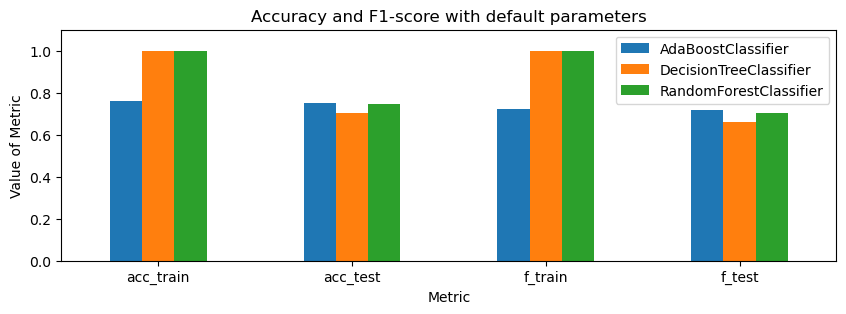

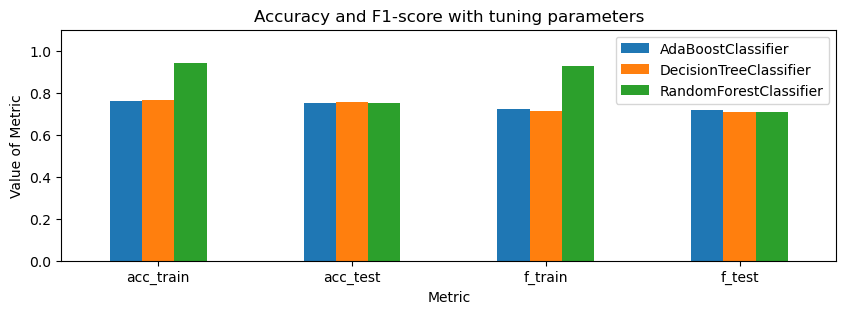

In [155]:
# Plot accuracy and f1-score for classifier with default parameters
pred_results_df.plot(x = "Metric", 
        y = ["AdaBoostClassifier", "DecisionTreeClassifier", "RandomForestClassifier"], 
        kind = "bar",
        figsize = (10, 3))
plt.title("Accuracy and F1-score with default parameters")
plt.xticks(rotation = 0)
plt.ylabel("Value of Metric", fontsize = 10)
plt.ylim(0, 1.1)
plt.show()

# Plot accuracy and f1-score for classifier with tuning parameters
pred_results_new_df.plot(x = "Metric", 
        y = ["AdaBoostClassifier", "DecisionTreeClassifier", "RandomForestClassifier"], 
        kind = "bar",
        figsize = (10, 3))
plt.title("Accuracy and F1-score with tuning parameters")
plt.xticks(rotation = 0)
plt.ylabel("Value of Metric", fontsize = 10)
plt.ylim(0, 1.1)
plt.show()

#### Conclusion for computed accuracy and f1-score

RandomForest Classifier has the best performace in accuracy and the second best performance in f1-score with test data. However, the values ​​for accuracy and f1-score are very close to each other for all 3 classifiers.

For further investigations with the customar spefific data, the accuracy with test date is carried out with all 3 classifiers. This means that the results can be compared accordingly when using the classifiers, but it can also be shown that the results of the 3 classifiers are also similar to one another.



In [191]:
# Dictionary with bogo_discount_informational data, name of dataframe and dataframe
my_data_dict = {'bogo_male_old_rich': bogo_male_old_rich_pd,
                'bogo_male_old_poor': bogo_male_old_poor_pd,
                'bogo_male_young_rich': bogo_male_young_rich_pd,
                'bogo_male_young_poor': bogo_male_young_poor_pd,
                'bogo_female_old_rich': bogo_female_old_rich_pd,
                'bogo_female_old_poor': bogo_female_old_poor_pd,
                'bogo_female_young_rich': bogo_female_young_rich_pd,
                'bogo_female_young_poor': bogo_female_young_poor_pd,
                'discount_male_old_rich': discount_male_old_rich_pd,
                'discount_male_old_poor': discount_male_old_poor_pd,
                'discount_male_young_rich': discount_male_young_rich_pd,
                'discount_male_young_poor': discount_male_young_poor_pd,
                'discount_female_old_rich': discount_female_old_rich_pd,
                'discount_female_old_poor': discount_female_old_poor_pd,
                'discount_female_young_rich': discount_female_young_rich_pd,
                'discount_female_young_poor': discount_female_young_poor_pd,
                'informational_male_old_rich': informational_male_old_rich_pd,
                'informational_male_old_poor': informational_male_old_poor_pd,
                'informational_male_young_rich': informational_male_young_rich_pd,
                'informational_male_young_poor': informational_male_young_poor_pd,
                'informational_female_old_rich': informational_female_old_rich_pd,
                'informational_female_old_poor': informational_female_old_poor_pd, 
                'informational_female_young_rich': informational_female_young_rich_pd,
                'informational_female_young_poor': informational_female_young_poor_pd, 
               }

In [192]:
# Convert keys and values from dictionary into lists
my_data_list = my_data_dict.values()
my_data_name_list = my_data_dict.keys()

In [207]:
# Function for computing accuracy
def compute_accuracy(data):
    '''
    Calculate accuracy with 3 Classifiers with tuning parameters
    
    INPUT: DataFrames from (my_data_list, my_data_list_new)
    
    OUTPUT: accuracy for the input data
    '''

    # Train- and test data
    X = np.array(data.loc[:,data.columns != 'transaction'])
    y = np.array(data['transaction'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
        
    clf_abc_new = AdaBoostClassifier(n_estimators = 20, learning_rate = 0.9, random_state = 42)
    clf_abc_new = clf_abc_new.fit(X_train, y_train)
    y_pred_abc = clf_abc_new.predict(X_test)
    
    clf_dtc_new = DecisionTreeClassifier(criterion = 'gini', max_depth = 6, min_samples_leaf = 1, min_samples_split = 2, random_state = 42)
    clf_dtc_new = clf_dtc_new.fit(X_train, y_train)
    y_pred_dtc = clf_dtc_new.predict(X_test)
    
    clf_rfc_new = RandomForestClassifier(bootstrap = True, criterion = 'gini', max_depth = 20, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 23, max_features = 'auto', random_state = 42)
    clf_rfc_new = clf_rfc_new.fit(X_train, y_train)
    y_pred_rfc = clf_rfc_new.predict(X_test)
        
    accuracy_abc_test = accuracy_score(y_test, y_pred_abc)
    accuracy_dtc_test = accuracy_score(y_test, y_pred_dtc)
    accuracy_rfc_test = accuracy_score(y_test, y_pred_rfc)

    return accuracy_abc_test, accuracy_dtc_test, accuracy_rfc_test
    #return accuracy_dtc_test

In [196]:
# Calculate the accuracy for bogo, discount and informational
my_accuracy_list = []

for d in my_data_list:
    accuracy = compute_accuracy(d)
    my_accuracy_list.append(accuracy)

In [197]:
# Convert List into dataframe
my_accuracy_list_df = pd.DataFrame(my_accuracy_list)
column_names = ['acc_abc', 'acc_dtc', 'acc_rfc']
my_accuracy_list_df.columns = column_names

# Seperate clf specific data
my_accuracy_list_df_abc = my_accuracy_list_df['acc_abc']
my_accuracy_list_df_dtc = my_accuracy_list_df['acc_dtc']
my_accuracy_list_df_rfc = my_accuracy_list_df['acc_rfc']

# Zip my_accuracy_data_name_list and my_accuracy_list_<clf> and convert to df
my_accuracy_data_name_df = pd.DataFrame(list(zip(my_data_name_list, 
                                                 my_accuracy_list_df_abc, 
                                                 my_accuracy_list_df_dtc, 
                                                 my_accuracy_list_df_rfc)))

column_names = ['customer_group', 'accuracy_abc', 'accuracy_dtc', 'accuracy_rfc']
my_accuracy_data_name_df.columns = column_names

In [198]:
my_accuracy_data_name_df

,customer_group,accuracy_abc,accuracy_dtc,accuracy_rfc
0,bogo_male_old_rich,0.640876,0.612409,0.627007
1,bogo_male_old_poor,0.710352,0.676211,0.674009
2,bogo_male_young_rich,0.686495,0.654341,0.694534
3,bogo_male_young_poor,0.715556,0.700000,0.700000
4,bogo_female_old_rich,0.685830,0.655870,0.650202
5,bogo_female_old_poor,0.676630,0.676630,0.663043
6,bogo_female_young_rich,0.639098,0.640602,0.625564
7,bogo_female_young_poor,0.663067,0.617711,0.634989
8,discount_male_old_rich,0.696970,0.708514,0.690476
9,discount_male_old_poor,0.744160,0.735261,0.756396


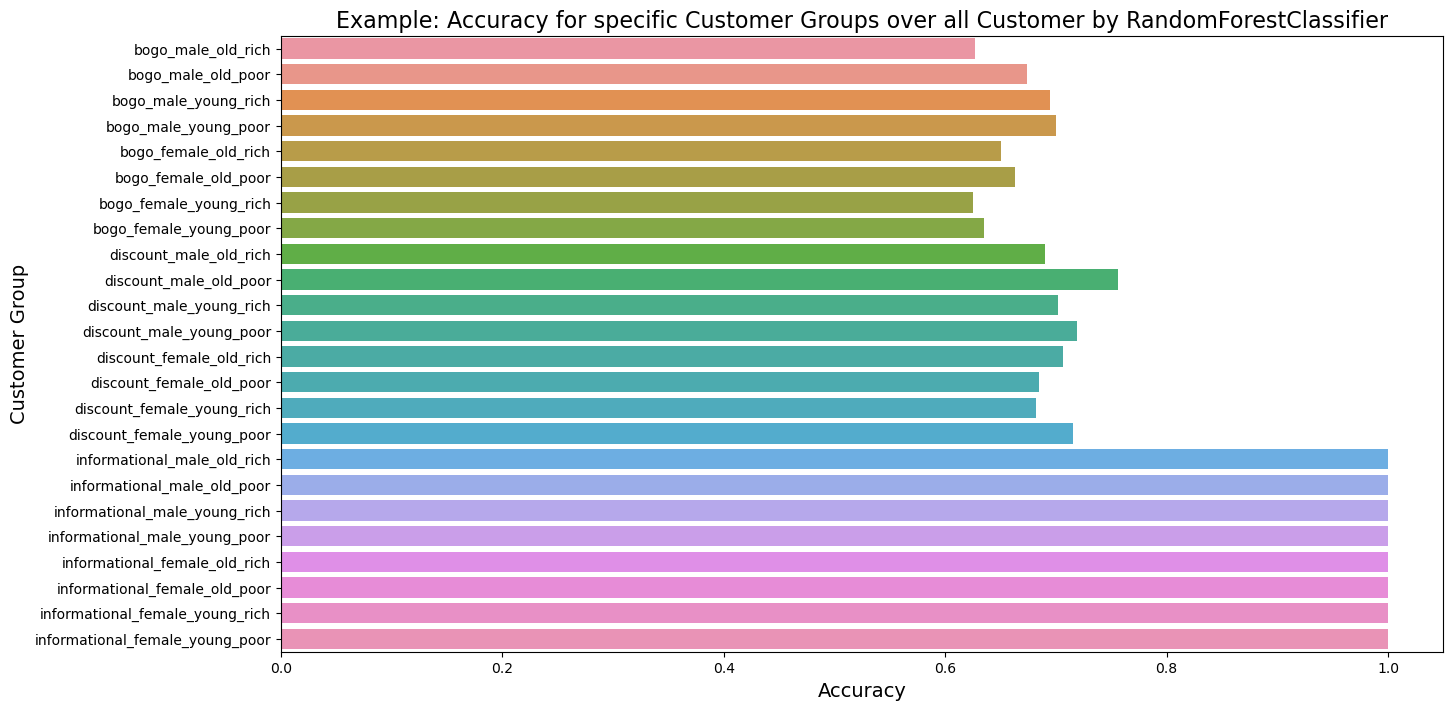

In [199]:
# Plot accuracy with bogo, discount and informational data
plt.figure(figsize=(15,8))
sns.barplot(data = my_accuracy_data_name_df,
            x = 'accuracy_rfc', 
            y = 'customer_group')

plt.xlabel("Accuracy", fontsize = 14)
plt.ylabel("Customer Group", fontsize = 14)
plt.title('Example: Accuracy for specific Customer Groups over all Customer by RandomForestClassifier', size = 16)
plt.show()

#### Conclusion for computed accuracy for 'BOGO', 'discount' and 'informational' "gender-age-income-specific" data

As expected, the precision in all cases for the 'informational' data = 1 becaus in train data and test data the value of 'transaction' is in all datasets = 0.

For the specific data, the accuracy is between 0.625564 (bogo_female_young_rich) and 0.756396 (discount_male_old_poor). There are no outliers or other abnormalities in the accuracy values ​​apart from the facts presented in point 1.

Let's try.

### Computing of the accuracy for 'BOGO' and 'discount'  "gender-age-income-specific" data
#### Dictionary of data to be considered for which accuracy is to be calculated

In [163]:
# Dictionary with bogo_discount data, name of dataframe and dataframe
my_data_dict_new = {'bogo_male_old_rich': bogo_male_old_rich_pd,
                'bogo_male_old_poor': bogo_male_old_poor_pd,
                'bogo_male_young_rich': bogo_male_young_rich_pd,
                'bogo_male_young_poor': bogo_male_young_poor_pd,
                'bogo_female_old_rich': bogo_female_old_rich_pd,
                'bogo_female_old_poor': bogo_female_old_poor_pd,
                'bogo_female_young_rich': bogo_female_young_rich_pd,
                'bogo_female_young_poor': bogo_female_young_poor_pd,
                'discount_male_old_rich': discount_male_old_rich_pd,
                'discount_male_old_poor': discount_male_old_poor_pd,
                'discount_male_young_rich': discount_male_young_rich_pd,
                'discount_male_young_poor': discount_male_young_poor_pd,
                'discount_female_old_rich': discount_female_old_rich_pd,
                'discount_female_old_poor': discount_female_old_poor_pd,
                'discount_female_young_rich': discount_female_young_rich_pd,
                'discount_female_young_poor': discount_female_young_poor_pd,
               }

In [164]:
# Convert keys and values from dictionary into lists
my_data_list_new = my_data_dict_new.values()
my_data_name_list_new = my_data_dict_new.keys()

In [165]:
# Calculate accuracy
my_accuracy_list_new = []

for d in my_data_list_new:
    accuracy = compute_accuracy(d)
    my_accuracy_list_new.append(accuracy)

In [166]:
# Convert List into dataframe
my_accuracy_list_df_new = pd.DataFrame(my_accuracy_list_new)
column_names = ['acc_abc', 'acc_dtc', 'acc_rfc']
my_accuracy_list_df_new.columns = column_names

# Seperate clf specific data
my_accuracy_list_df_abc_new = my_accuracy_list_df_new['acc_abc']
my_accuracy_list_df_dtc_new = my_accuracy_list_df_new['acc_dtc']
my_accuracy_list_df_rfc_new = my_accuracy_list_df['acc_rfc']

# Zip my_accuracy_data_name_list and my_accuracy_list_<clf> and convert to df
my_accuracy_data_name_df_new = pd.DataFrame(list(zip(my_data_name_list_new, 
                                                 my_accuracy_list_df_abc_new, 
                                                 my_accuracy_list_df_dtc_new, 
                                                 my_accuracy_list_df_rfc_new)))

column_names = ['customer_group', 'accuracy_abc', 'accuracy_dtc', 'accuracy_rfc']
my_accuracy_data_name_df_new.columns = column_names

In [167]:
my_accuracy_data_name_df_new

,customer_group,accuracy_abc,accuracy_dtc,accuracy_rfc
0,bogo_male_old_rich,0.640876,0.612409,0.627007
1,bogo_male_old_poor,0.710352,0.676211,0.674009
2,bogo_male_young_rich,0.686495,0.654341,0.694534
3,bogo_male_young_poor,0.715556,0.700000,0.700000
4,bogo_female_old_rich,0.685830,0.655870,0.650202
5,bogo_female_old_poor,0.676630,0.676630,0.663043
6,bogo_female_young_rich,0.639098,0.640602,0.625564
7,bogo_female_young_poor,0.663067,0.617711,0.634989
8,discount_male_old_rich,0.696970,0.708514,0.690476
9,discount_male_old_poor,0.744160,0.735261,0.756396


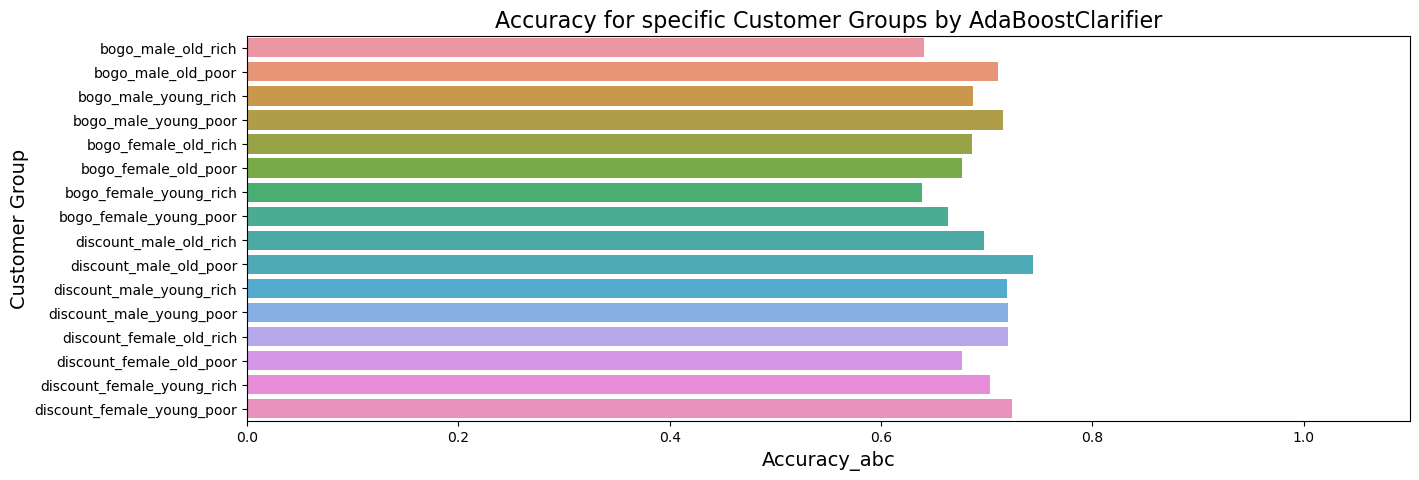

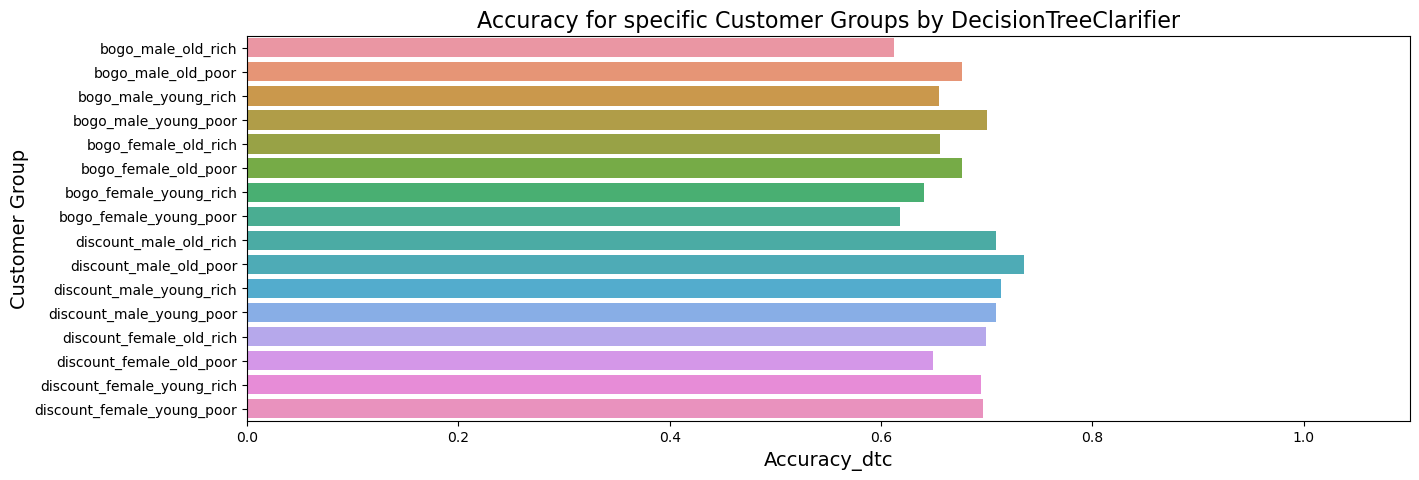

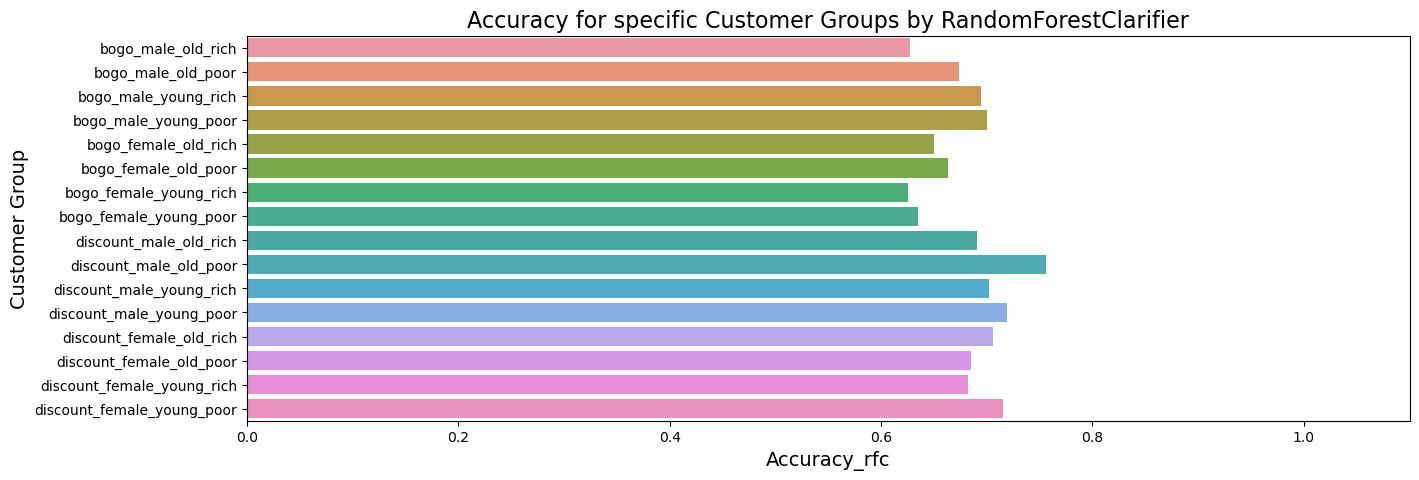

In [168]:
# Plot the accuracy with bogo and discount data
plt.figure(figsize=(15,5))
sns.barplot(data = my_accuracy_data_name_df_new,
            x = 'accuracy_abc', 
            y = 'customer_group')
plt.xlabel("Accuracy_abc", fontsize = 14)
plt.ylabel("Customer Group", fontsize = 14)
plt.xlim(0, 1.1)
plt.title('Accuracy for specific Customer Groups by AdaBoostClarifier', size = 16)
plt.show()

plt.figure(figsize=(15,5))
sns.barplot(data = my_accuracy_data_name_df_new,
            x = 'accuracy_dtc', 
            y = 'customer_group')
plt.xlabel("Accuracy_dtc", fontsize = 14)
plt.ylabel("Customer Group", fontsize = 14)
plt.xlim(0, 1.1)
plt.title('Accuracy for specific Customer Groups by DecisionTreeClarifier', size = 16)
plt.show()

plt.figure(figsize=(15,5))
sns.barplot(data = my_accuracy_data_name_df_new,
            x = 'accuracy_rfc', 
            y = 'customer_group')
plt.xlabel("Accuracy_rfc", fontsize = 14)
plt.ylabel("Customer Group", fontsize = 14)
plt.xlim(0, 1.1)
plt.title('Accuracy for specific Customer Groups by RandomForestClarifier', size = 16)
plt.show()

### What is the delta in accuracy between the 'BOGO' data and the 'discount' data?
#### Calculate the delta in accuracy between bogo and discout data
#### 1. Create the Deltas

In [179]:
my_accuracy_data_name_df_new

,customer_group,accuracy_abc,accuracy_dtc,accuracy_rfc
0,bogo_male_old_rich,0.640876,0.612409,0.627007
1,bogo_male_old_poor,0.710352,0.676211,0.674009
2,bogo_male_young_rich,0.686495,0.654341,0.694534
3,bogo_male_young_poor,0.715556,0.700000,0.700000
4,bogo_female_old_rich,0.685830,0.655870,0.650202
5,bogo_female_old_poor,0.676630,0.676630,0.663043
6,bogo_female_young_rich,0.639098,0.640602,0.625564
7,bogo_female_young_poor,0.663067,0.617711,0.634989
8,discount_male_old_rich,0.696970,0.708514,0.690476
9,discount_male_old_poor,0.744160,0.735261,0.756396


In [182]:
# Only accuracy_abc with bogo data
my_accuracy_bogo_abc = my_accuracy_data_name_df_new[:8]['accuracy_abc']
my_accuracy_bogo_abc = pd.DataFrame(my_accuracy_bogo_abc)
my_accuracy_bogo_abc.rename(columns = {'accuracy_abc': 'acc_bogo_abc'}, inplace = True)

# Only accuracy_abc with discount data
my_accuracy_discount_abc = my_accuracy_data_name_df_new[8:]['accuracy_abc']
my_accuracy_discount_abc = pd.DataFrame(my_accuracy_discount_abc)
my_accuracy_discount_abc.rename(columns = {'accuracy_abc': 'acc_discount_abc'}, inplace = True)
my_accuracy_discount_abc = my_accuracy_discount_abc.rename_axis('index').reset_index()
my_accuracy_discount_abc = my_accuracy_discount_abc.drop('index', axis = 1)

In [183]:
my_accuracy_discount_abc

,acc_discount_abc
0,0.696970
1,0.744160
2,0.719493
3,0.720490
4,0.720447
5,0.676796
6,0.703364
7,0.723769


In [185]:
# Common data with delta accuracy
consumer_groups =['male_old_rich',
                  'male_old_poor', 
                  'male_young_rich', 
                  'male_young_poor', 
                  'female_old_rich', 
                  'female_old_poor', 
                  'female_young_rich', 
                  'female_young_poor']

my_accuracy_delta_abc = my_accuracy_bogo_abc.join(my_accuracy_discount_abc)

my_accuracy_delta_abc.insert(loc = len(my_accuracy_delta_abc.columns), 
                         column='acc_delta_abc', 
                         value = my_accuracy_delta_abc.acc_discount_abc - my_accuracy_delta_abc.acc_bogo_abc)

my_accuracy_delta_abc.insert(loc = len(my_accuracy_delta_abc.columns), 
                         column='customer_group', 
                         value = consumer_groups)
my_accuracy_delta_abc

,acc_bogo_abc,acc_discount_abc,acc_delta_abc,customer_group
0,0.640876,0.696970,0.056094,male_old_rich
1,0.710352,0.744160,0.033808,male_old_poor
2,0.686495,0.719493,0.032998,male_young_rich
3,0.715556,0.720490,0.004934,male_young_poor
4,0.685830,0.720447,0.034617,female_old_rich
5,0.676630,0.676796,0.000165,female_old_poor
6,0.639098,0.703364,0.064266,female_young_rich
7,0.663067,0.723769,0.060702,female_young_poor


In [186]:
# Only accuracy_dtc with bogo data
my_accuracy_bogo_dtc = my_accuracy_data_name_df_new[:8]['accuracy_dtc']
my_accuracy_bogo_dtc = pd.DataFrame(my_accuracy_bogo_dtc)
my_accuracy_bogo_dtc.rename(columns = {'accuracy_dtc': 'acc_bogo_dtc'}, inplace = True)

# Only accuracy_dtc with discount data
my_accuracy_discount_dtc = my_accuracy_data_name_df_new[8:]['accuracy_dtc']
my_accuracy_discount_dtc = pd.DataFrame(my_accuracy_discount_dtc)
my_accuracy_discount_dtc.rename(columns = {'accuracy_dtc': 'acc_discount_dtc'}, inplace = True)
my_accuracy_discount_dtc = my_accuracy_discount_dtc.rename_axis('index').reset_index()
my_accuracy_discount_dtc = my_accuracy_discount_dtc.drop('index', axis = 1)

In [187]:
my_accuracy_discount_dtc

,acc_discount_dtc
0,0.708514
1,0.735261
2,0.713154
3,0.708241
4,0.699681
5,0.649171
6,0.694190
7,0.695931


In [208]:
# Common data with delta accuracy
consumer_groups =['male_old_rich',
                  'male_old_poor', 
                  'male_young_rich', 
                  'male_young_poor', 
                  'female_old_rich', 
                  'female_old_poor', 
                  'female_young_rich', 
                  'female_young_poor']

my_accuracy_delta_dtc = my_accuracy_bogo_dtc.join(my_accuracy_discount_dtc)

my_accuracy_delta_dtc.insert(loc = len(my_accuracy_delta_dtc.columns), 
                         column='acc_delta_dtc', 
                         value = my_accuracy_delta_dtc.acc_discount_dtc - my_accuracy_delta_dtc.acc_bogo_dtc)

my_accuracy_delta_dtc.insert(loc = len(my_accuracy_delta_dtc.columns), 
                         column='customer_group', 
                         value = consumer_groups)
my_accuracy_delta_dtc

,acc_bogo_dtc,acc_discount_dtc,acc_delta_dtc,customer_group
0,0.612409,0.708514,0.096105,male_old_rich
1,0.676211,0.735261,0.059050,male_old_poor
2,0.654341,0.713154,0.058813,male_young_rich
3,0.700000,0.708241,0.008241,male_young_poor
4,0.655870,0.699681,0.043810,female_old_rich
5,0.676630,0.649171,-0.027459,female_old_poor
6,0.640602,0.694190,0.053588,female_young_rich
7,0.617711,0.695931,0.078221,female_young_poor


In [213]:
# Only accuracy_rfc with bogo data
my_accuracy_bogo_rfc = my_accuracy_data_name_df_new[:8]['accuracy_rfc']
my_accuracy_bogo_rfc = pd.DataFrame(my_accuracy_bogo_rfc)
my_accuracy_bogo_rfc.rename(columns = {'accuracy_rfc': 'acc_bogo_rfc'}, inplace = True)

# Only accuracy_dtc with discount data
my_accuracy_discount_rfc = my_accuracy_data_name_df_new[8:]['accuracy_rfc']
my_accuracy_discount_rfc = pd.DataFrame(my_accuracy_discount_rfc)
my_accuracy_discount_rfc.rename(columns = {'accuracy_rfc': 'acc_discount_rfc'}, inplace = True)
my_accuracy_discount_rfc = my_accuracy_discount_rfc.rename_axis('index').reset_index()
my_accuracy_discount_rfc = my_accuracy_discount_rfc.drop('index', axis = 1)

In [214]:
# Common data with delta accuracy
consumer_groups =['male_old_rich',
                  'male_old_poor', 
                  'male_young_rich', 
                  'male_young_poor', 
                  'female_old_rich', 
                  'female_old_poor', 
                  'female_young_rich', 
                  'female_young_poor']

my_accuracy_delta_rfc = my_accuracy_bogo_rfc.join(my_accuracy_discount_rfc)

my_accuracy_delta_rfc.insert(loc = len(my_accuracy_delta_rfc.columns), 
                         column='acc_delta_rfc', 
                         value = my_accuracy_delta_rfc.acc_discount_rfc - my_accuracy_delta_rfc.acc_bogo_rfc)

my_accuracy_delta_rfc.insert(loc = len(my_accuracy_delta_rfc.columns), 
                         column='customer_group', 
                         value = consumer_groups)
my_accuracy_delta_rfc

,acc_bogo_rfc,acc_discount_rfc,acc_delta_rfc,customer_group
0,0.627007,0.690476,0.063469,male_old_rich
1,0.674009,0.756396,0.082387,male_old_poor
2,0.694534,0.702060,0.007526,male_young_rich
3,0.700000,0.719376,0.019376,male_young_poor
4,0.650202,0.706070,0.055868,female_old_rich
5,0.663043,0.685083,0.022039,female_old_poor
6,0.625564,0.681957,0.056393,female_young_rich
7,0.634989,0.715203,0.080214,female_young_poor


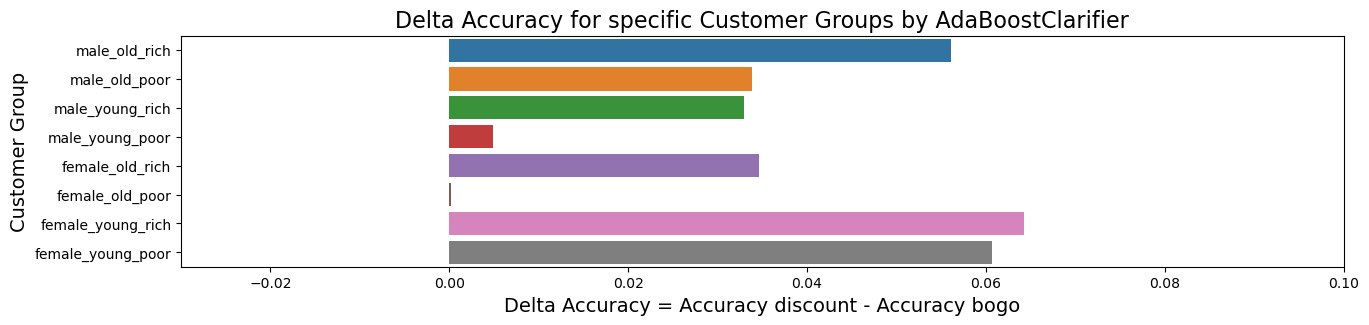

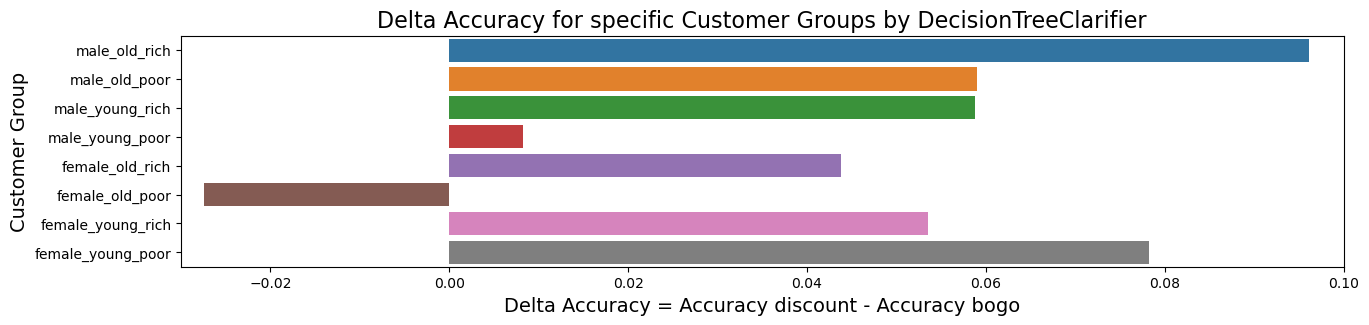

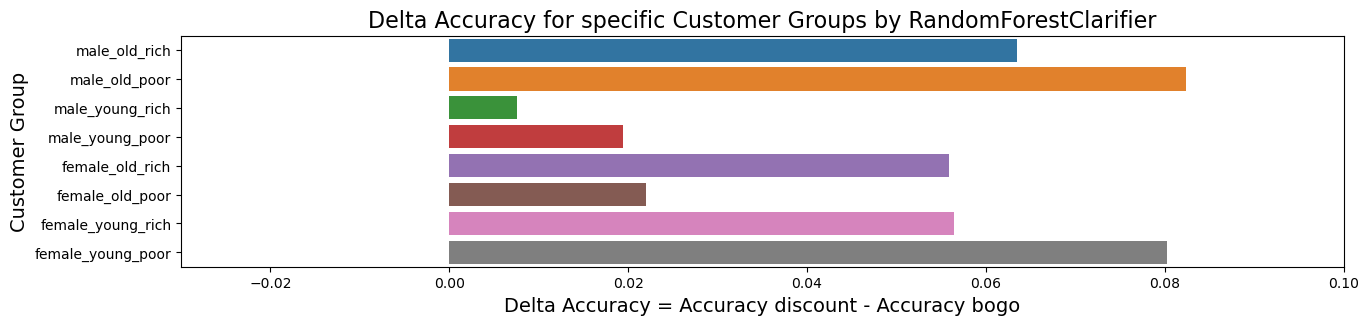

In [215]:
# Plot the delta accuracy with bogo and discount data for the specific customer groups
plt.figure(figsize=(15,3))
sns.barplot(data = my_accuracy_delta_abc, 
            x = 'acc_delta_abc', 
            y = 'customer_group')
plt.xlabel("Delta Accuracy = Accuracy discount - Accuracy bogo", fontsize = 14)
plt.ylabel("Customer Group", fontsize = 14)
plt.xlim(-0.03, 0.1)
plt.title('Delta Accuracy for specific Customer Groups by AdaBoostClarifier', size = 16)
plt.show()

plt.figure(figsize=(15,3))
sns.barplot(data = my_accuracy_delta_dtc, 
            x = 'acc_delta_dtc', 
            y = 'customer_group')
plt.xlabel("Delta Accuracy = Accuracy discount - Accuracy bogo", fontsize = 14)
plt.ylabel("Customer Group", fontsize = 14)
plt.xlim(-0.03, 0.1)
plt.title('Delta Accuracy for specific Customer Groups by DecisionTreeClarifier', size = 16)
plt.show()

plt.figure(figsize=(15,3))
sns.barplot(data = my_accuracy_delta_rfc, 
            x = 'acc_delta_rfc', 
            y = 'customer_group')
plt.xlabel("Delta Accuracy = Accuracy discount - Accuracy bogo", fontsize = 14)
plt.ylabel("Customer Group", fontsize = 14)
plt.xlim(-0.03, 0.1)
plt.title('Delta Accuracy for specific Customer Groups by RandomForestClarifier', size = 16)
plt.show()

#### Conclusion for computed accuracy for 'BOGO' and 'discount' "gender-age-income-specific" data
It can be seen that the accuracy of the 'discount' specific data is always higher than the accuracy of the 'BOGO' specific data. Exception: accuracy(discount_female_old_poor) in DecisionTreeClarifier.

The difference in accuracy in the customer groups is not extreme but significant. The largest delta in accuracy is at male_old_rich in DecisionTreeClarifier with acc_delta = 0.096105. Based on the accuracy(bogo_male_old_rich) , this is a deviation of about 16% upwards. This means that the accuracy of the prediction with DecisionTreeClarifier for the customer group male_old_rich is about 16% better for the offer 'discount' than for the offer 'BOGO'.

In mine opinion, it should be checked whether the knowledge acquired in this way can be transferred to real scenarios and which measures for addressing customers can be derived from this. In particular, it should be noted that real data contains significantly more customer data and also a significantly larger portfolio of offers. From the large amount of customer data, more precise statistical evaluations can be carried out with more precise results for the predictions.

Finally, a critical note on the procedure: From the accuracy data obtained, it can be deduced that further customer characteristics should be collected from those customer groups with a relatively low level of accuracy in order to increase the reliability of the prediction as to whether the customer will accept the offer or not. This means that customers can be addressed more specifically with the offers that are relevant to them. The question therefore arises as to whether it is worth the extra effort to prepare the consumer data in such a way that the best offer can be made for the consumer of a certain type.


In [ ]:


from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_notebook.ipynb'])

